In [61]:
import random
import string
import torch
import numpy as np
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [71]:
def generate_next_token_after_first_occurrence_dataset(n, T, k, seed=None):
    """
    Génère un dataset où le modèle doit prédire la lettre qui suit
    la première apparition de la dernière lettre de la séquence.

    Retourne :
        X: [n, T, D] one-hot
        y: [n] target class (entier entre 0 et k-1)
    """
    import random
    import numpy as np
    import torch

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    alphabet = list(string.ascii_uppercase[:k])
    char_to_id = {c: i for i, c in enumerate(alphabet)}
    id_to_char = {i: c for c, i in char_to_id.items()}
    D = len(alphabet)
    eye = np.eye(D)

    X = []
    y = []

    for _ in range(n):
        seq = random.choices(alphabet, k=T)
        x_seq = [eye[char_to_id[c]] for c in seq]
        X.append(x_seq)

        last_char = seq[-1]
        try:
            first_index = seq.index(last_char)
            if first_index < T - 1:
                next_char = seq[first_index + 1]
                y.append(char_to_id[next_char])
            else:
                y.append(char_to_id[last_char])  # fallback: nothing after, predict itself
        except ValueError:
            y.append(char_to_id[last_char])  # should never happen

    return (
        torch.tensor(X, dtype=torch.float32),  # [n, T, D]
        torch.tensor(y, dtype=torch.long),     # [n]
        char_to_id,
        id_to_char
    )


In [6]:
def generate_next_token_prediction_dataset(n, T, k, seed=None):
    """
    Génère un dataset où le modèle doit prédire la lettre la plus fréquente
    suivant la dernière lettre d'une séquence.

    Retourne :
        X: [n, T, D] one-hot
        y: [n] target class (entier entre 0 et k-1)
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    alphabet = list(string.ascii_uppercase[:k])
    char_to_id = {c: i for i, c in enumerate(alphabet)}
    id_to_char = {i: c for c, i in char_to_id.items()}
    D = len(alphabet)
    eye = np.eye(D)

    X = []
    y = []

    for _ in range(n):
        seq = random.choices(alphabet, k=T)
        x_seq = [eye[char_to_id[c]] for c in seq]
        X.append(x_seq)

        last_char = seq[-1]
        following = [seq[i+1] for i in range(len(seq)-1) if seq[i] == last_char]
        if following:
            most_common = Counter(following).most_common(1)[0][0]
            y.append(char_to_id[most_common])
        else:
            y.append(char_to_id[last_char])  # fallback: prédire la même lettre

    return (
        torch.tensor(X, dtype=torch.float32),  # [n, T, D]
        torch.tensor(y, dtype=torch.long),     # [n]
        char_to_id,
        id_to_char
    )


In [35]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)


In [43]:
class AttentionOnlyBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.attn_weights = None

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        attn = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        weights = torch.softmax(attn, dim=-1)
        self.attn_weights = weights
        x = x + torch.matmul(weights, V)
        return self.norm(x)
    
class SequenceClassifier(nn.Module):
    def __init__(self, input_dim, d_model=64, num_layers=2, num_classes=5):
        super().__init__()
        self.embed = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([AttentionOnlyBlock(d_model) for _ in range(num_layers)])
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embed(x)  # [B, T, D]
        x = self.pos_enc(x)
        for layer in self.layers:
            x = layer(x)
        x = x.transpose(1, 2)  # [B, D, T]
        x = self.pool(x).squeeze(-1)  # [B, D]
        return self.fc(x)  # [B, C]


In [44]:
def train_classifier(model, train_loader, test_loader, epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Évaluation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                pred_class = preds.argmax(dim=-1)
                correct += (pred_class == yb).sum().item()
                total += yb.size(0)
        acc = correct / total
        print(f"Epoch {epoch}/{epochs} | Train Loss: {total_loss/len(train_loader):.4f} | Val Acc: {acc:.4f}")


In [45]:
def tensor_to_letter_sequence(tensor, id_to_char):
    """
    Convertit un tenseur [T, D] ou [B, T, D] en séquence(s) de lettres.
    
    Args:
        tensor: torch.Tensor of shape [T, D] or [B, T, D]
        id_to_char: dict mapping index to character

    Returns:
        Une string (si [T, D]) ou une liste de strings (si [B, T, D])
    """
    if tensor.dim() == 2:
        indices = tensor.argmax(dim=-1)  # [T]
        return ''.join([id_to_char[i.item()] for i in indices])
    elif tensor.dim() == 3:
        return [''.join([id_to_char[i.item()] for i in seq.argmax(dim=-1)]) for seq in tensor]
    else:
        raise ValueError("Input tensor must be of shape [T, D] or [B, T, D]")


In [53]:
T = 50
D = 5

In [54]:
X, y, char_to_id, id_to_char = generate_next_token_prediction_dataset(n=80000, T=T, k=D)

In [55]:
# Générer les données



# Diviser en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=300, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test))


In [56]:
tensor_to_letter_sequence(X[0], id_to_char), tensor_to_letter_sequence(X[1], id_to_char), y[0].item(), y[1].item()

('AAADDAEEECBABEDEDEEAEEEAEABEDBBCACAEAAABEDEBDAEBDE',
 'CBDBDDBCABACABBCBDABCBACACDABDEDDEBDDAECDADDDACEBC',
 4,
 1)

In [70]:

# Initialiser et entraîner
model = SequenceClassifier(input_dim=5, num_classes=5, d_model=256, num_layers=4)
train_classifier(model, train_loader, test_loader)


Epoch 1/10 | Train Loss: 1.5462 | Val Acc: 0.3669
Epoch 2/10 | Train Loss: 1.4409 | Val Acc: 0.3802
Epoch 3/10 | Train Loss: 1.4255 | Val Acc: 0.3789
Epoch 4/10 | Train Loss: 1.4175 | Val Acc: 0.3950


KeyboardInterrupt: 

In [67]:
def plot_attention_matrices_with_accuracy(model, sequences, char_to_id, special_char='A', special_value=7, device='cuda' if torch.cuda.is_available() else 'cpu'):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import torch.nn.functional as F
    import numpy as np

    D = len(char_to_id)
    embeddings = np.eye(D)
    model.eval()

    num_sequences = len(sequences)
    fig, axs = plt.subplots(num_sequences, 2, figsize=(14, 3.5 * num_sequences))

    if num_sequences == 1:
        axs = [axs]

    for i, sequence in enumerate(sequences):
        x_seq = [embeddings[char_to_id[c]] for c in sequence]
        x_tensor = torch.tensor([x_seq], dtype=torch.float32).to(device)

        counts = {c: sequence.count(c) for c in char_to_id}
        y_target = torch.tensor([[
            special_value if c == special_char else counts[c]
            for c in sequence
        ]], dtype=torch.long).to(device)

        with torch.no_grad():
            logits = model(x_tensor).squeeze(0)  # [T, C]

        k = min(20, len(sequence))
        attn0 = F.softmax(model.layers[0].attn_weights, dim=-1).detach().squeeze(0).cpu().numpy()[:k, :k]


        sns.heatmap(attn0, cmap="viridis", xticklabels=sequence[:k], yticklabels=sequence[:k],
                    square=True, cbar=True, ax=axs[i][0])

        axs[i][0].set_xlabel("Attended Tokens")
        axs[i][0].set_ylabel("Attending Tokens")
        axs[i][0].tick_params(axis='x', rotation=90)

        attn1 = F.softmax(model.layers[1].attn_weights, dim=-1).detach().squeeze(0).cpu().numpy()[:k, :k]

        sns.heatmap(attn1, cmap="viridis", xticklabels=sequence[:k], yticklabels=sequence[:k],
                    square=True, cbar=True, ax=axs[i][1])

        axs[i][1].set_xlabel("Attended Tokens")
        axs[i][1].set_ylabel("Attending Tokens")
        axs[i][1].tick_params(axis='x', rotation=90)



    plt.tight_layout()
    plt.show()
    return fig


In [68]:
def generate_random_sequences(n, T, k, seed=None):
    """
    Génère `n` séquences de taille `T` avec un alphabet de `k` lettres (A, B, ..., jusqu’à k).
    """
    if seed is not None:
        random.seed(seed)

    alphabet = list(string.ascii_uppercase[:k])
    sequences = [random.choices(alphabet, k=T) for _ in range(n)]
    return sequences

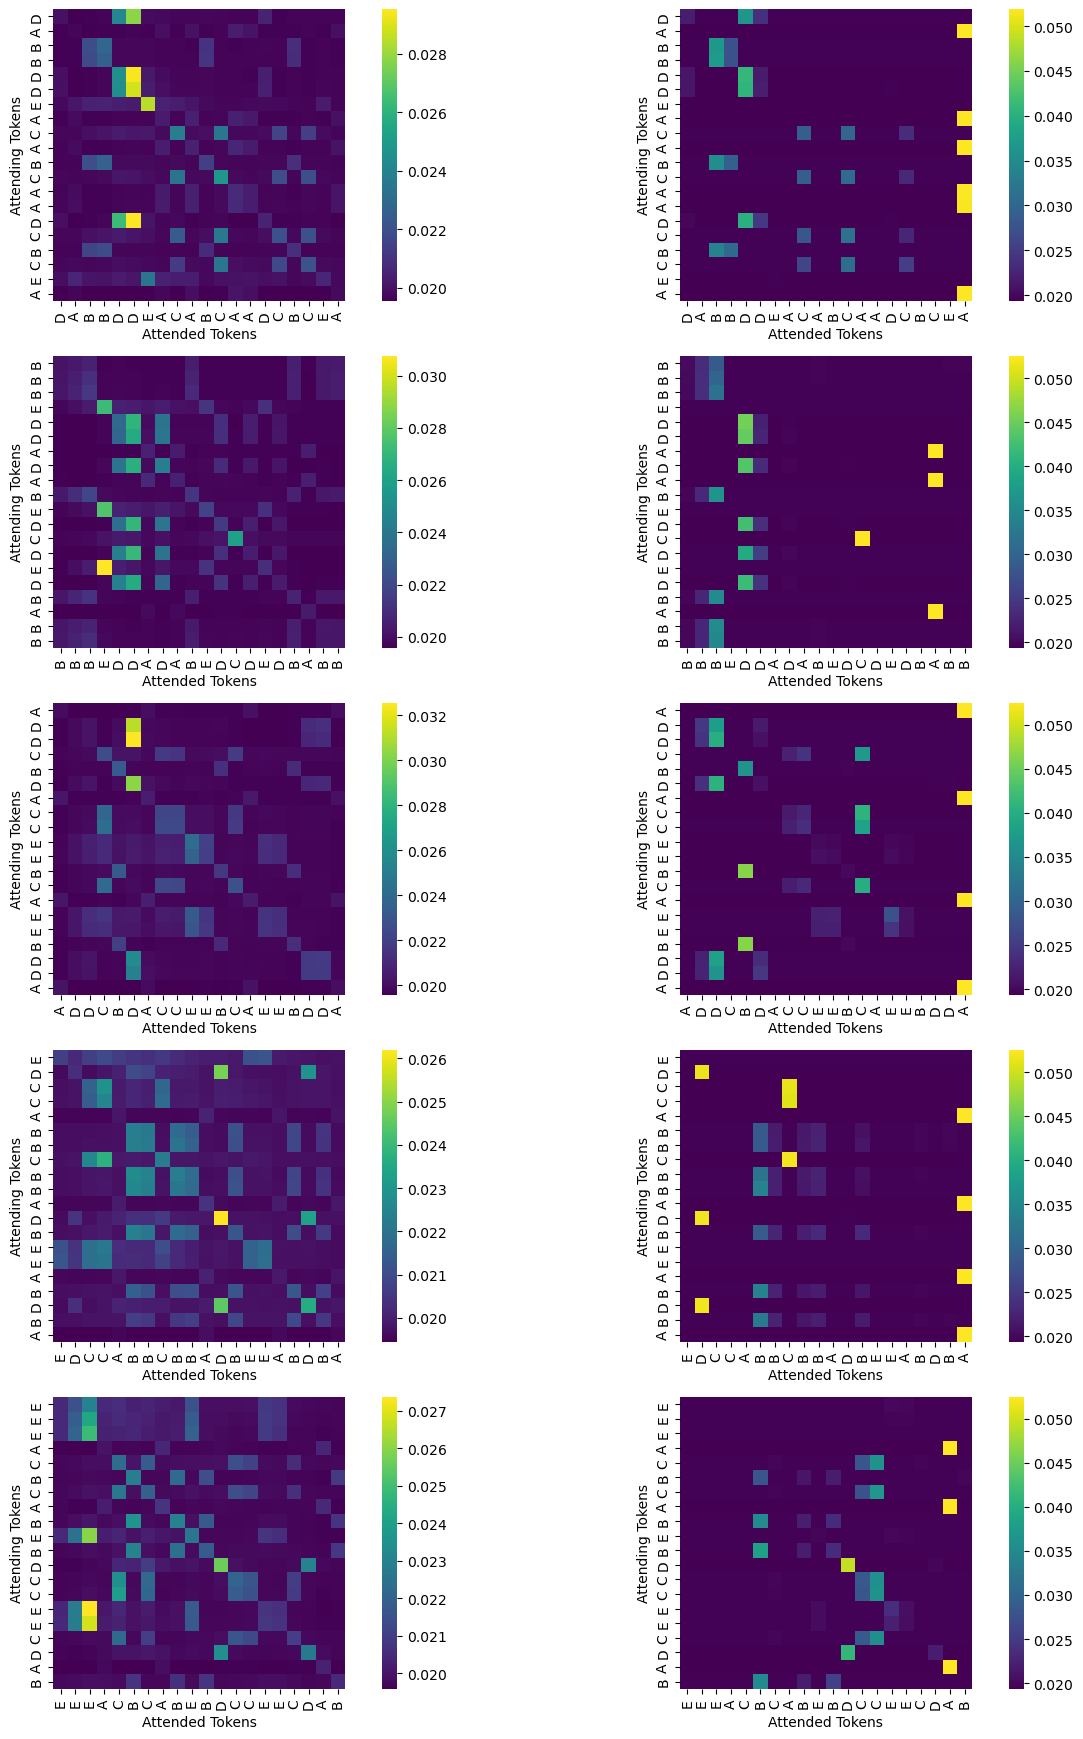

In [69]:
test_sequences = generate_random_sequences(n=5, T=T, k=D, seed=42)

fig = plot_attention_matrices_with_accuracy(
    model=model,
    sequences=test_sequences,
    char_to_id=char_to_id,
    special_char='A',
    special_value=7,
    device=device
)